# Detecting adapters

For datasets where the adapter is tricky in situations where non-standard adapters have been used or a barcode exists adjacent to the adapter.

# 3' adapters

This section is borrowed and copied as it is from the `cutadapt` [manual](https://cutadapt.readthedocs.io/en/v1.7.1/guide.html).


A 3’ adapter is a piece of DNA ligated to the 3’
end of the DNA fragment you are interested in. 
The sequencer starts the sequencing process at the 5’
end of the fragment and sequences into the adapter
if the read is long enough. 

The read that it outputs will then have a part of
the adapter in the end. Or, if the adapter was 
short and the read length quite long, then the adapter
will be somewhere within the read (followed by other bases).

For example, assume your fragment of interest
is MYSEQUENCE and the adapter is ADAPTER. 
Depending on the read length, 
you will get reads that look like this:

```
MYSEQUEN
MYSEQUENCEADAP
MYSEQUENCEADAPTER
MYSEQUENCEADAPTERSOMETHINGELSE
```

Use cutadapt’s -a ADAPTER option to remove this type of adapter. This will be the result:

```
MYSEQUEN
MYSEQUENCE
MYSEQUENCE
MYSEQUENCE
```
As can be seen, cutadapt correctly deals with partial adapter matches,
and also with any trailing sequences after the adapter.
Cutadapt deals with 3’ adapters by removing the adapter itself and 
any sequence that may follow.
If the sequence starts with an adapter, like this:
```
ADAPTERSOMETHING
```
Then the sequence will be empty after trimming. 
Note that, by default, empty reads are not discarded and will appear in the output.


NOTE: Our adapter in the above case is not "anchored" at the end. There is a seprate flag to handle that in `cutadapt`.

Here we perform various case studies where `cutadapt`'s auto-detection alone is not useful. 

The standard adapters are:


| Protocol |  Adapter     |
|----------|--------------|
|Illumina  | AGATCGGAAGAGC|
|Small RNA |  TGGAATTCTCGG|
|Nextera   |  CTGTCTCTTATA|

In [22]:
%pylab inline
%load_ext autoreload
%autoreload 2
import pandas as pd
from riboraptor.kmer import fastq_kmer_histogram

def get_top_kmers(kmer_series):
    """Return all kmers with cumulative sum <=50,
    because we won't need mroe than that.
    """
    cumsum = kmer_series.cumsum()
    return kmer_series[cumsum<=70]
    

Populating the interactive namespace from numpy and matplotlib
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
CTGTAGGCACCATCAAT
CTGTAGGC

In [3]:
# For this file the second pass works: SRR403893_trimmed.fq.gz
# Not for other files in /staging/as/skchoudh/re-ribo-analysis/hg38/SRP010679/preprocessed

histogram_1passfail = fastq_kmer_histogram('/staging/as/skchoudh/re-ribo-analysis/hg38/SRP010679/preprocessed_step1/SRR403891_trimmed.fq.gz')


100%|██████████| 1000000/1000000 [00:42<00:00, 23686.84it/s]


In [4]:
histogram_1passpass = fastq_kmer_histogram('/staging/as/skchoudh/re-ribo-analysis/hg38/SRP010679/preprocessed_step1/SRR403893_trimmed.fq.gz')


100%|██████████| 1000000/1000000 [00:41<00:00, 24007.22it/s]


In [23]:
ratios = {}
for key, value in histogram_1passfail.items():
    ratios[key] = value.values[0]/value.values[1]
ratios = pd.Series(ratios) 

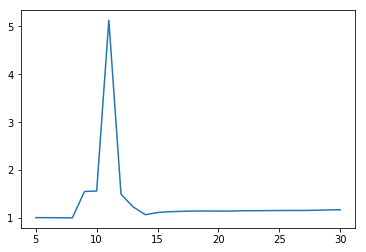

In [24]:
plt.plot(ratios.index, ratios.values)

In [2]:
fastqs = {'17nt': '/staging/as/skchoudh/re-ribo-analysis/hg38/SRP098789/sratofastq/SRR5227288.fastq.gz',
         '17nt_post_trimming': '/staging/as/skchoudh/re-ribo-analysis/hg38/SRP098789/preprocessed/SRR5227288_trimmed.fq.gz',
         '13nt': '/home/cmb-06/as/skchoudh/dna/Dec_12_2017_Penalva_RPS5_Riboseq/Penalva_L_12112017/RPS5_C2_S2_L001_R1_001.fastq.gz',
         '13nt_post_trimming': '/home/cmb-panasas2/skchoudh/rna/Dec_12_2017_Penalva_RPS5_RNAseq_and_Riboseq/preprocessed/RPS5_C2_S2_L001_R1_001_trimmed.fq.gz',
         'ambiguous': '/staging/as/skchoudh/re-ribo-analysis/hg38/SRP031501_human_remap_v2/sratofastq/SRR1562541.fastq.gz',
          'erx': '/staging/as/wenzhenl/re-ribo-data/ERP005378/ERX432360/ERR466125.fastq'
         }
histograms = {k:{} for k in fastqs.keys()}

In [3]:

for key, fastq in fastqs.items():
    histograms[key] = fastq_kmer_histogram(fastq)

100%|██████████| 1000000/1000000 [00:46<00:00, 21431.22it/s]


# A Dataset with 17nt adapter

The adapter for this dataset is 17nt long: CTGTAGGCACCATCAAT
We will first consider looking at the raw fastq to see if we find any enriched sequences.


In [5]:
get_top_kmers(histograms['17nt'][17])
#AGATCGGAAGAGC
#CACCATCAATAGATCGG

CACCATCAATAGATCGG    13.1623
GCACCATCAATAGATCG    13.0374
AGGCACCATCAATAGAT    12.9194
GGCACCATCAATAGATC    12.8873
ACCATCAATAGATCGGA     7.7049
TAGGCACCATCAATAGA     6.1639
dtype: float64

There does seem to be enrichment of some 17nt sequences (collpasing them on Levenshtein distance will lead to one sequence being >50%)

In [6]:
get_top_kmers(histograms['17nt_post_trimming'][17])

CTGTAGGCACCATCAAT    55.4321
CTGTAGGCCCCATCAAT     9.0573
GACCCGGTGAGGCGGGG     3.8465
dtype: float64

This should also highlight the need to trim twice. Let's look at the original 17nt enrichment sequence (before anytrimming). The top sequence is:

CACCATCAATAGATCGG. Looking closely, it should not be difficult to realize that there is illumina standard adapter (`AGATCGGAAGAGC`) thrown somewhere in between.

CACCATCAAT**AGATCGG**. So trimming gets rid of these partial adapters and the rest of the overrepresented sequence shows enrichment, which is not so clear
without trimming.

To make sure 17nt indeed is the adapter, we can go one nucleotide up:


In [7]:
get_top_kmers(histograms['17nt_post_trimming'][18])

GCTGTAGGCACCATCAAT    22.4646
TCTGTAGGCACCATCAAT    11.7972
CCTGTAGGCACCATCAAT    11.4453
ACTGTAGGCACCATCAAT     9.7249
GCTGTAGGCCCCATCAAT     4.9783
TGACCCGGTGAGGCGGGG     3.8444
ACTGACCCGGTGAGGCGG     1.9585
TCTGTAGGCCCCATCAAT     1.4981
CCTGTAGGCCCCATCAAT     1.4754
dtype: float64

# Dataset with 13nt adapter

Let's try do do the same with a fastq where we know the adpter is 13 nt long.


In [8]:
get_top_kmers(histograms['13nt'][13])


AAGAGCACACGTC    16.1245
AGAGCACACGTCT    14.1972
GAGCACACGTCTG     9.9697
GAAGAGCACACGT     9.1139
AGCACACGTCTGA     8.7303
GGAAGAGCACACG     8.2685
dtype: float64

Again, the first four sequences are essentially within a Levenshtein distance of 1-2nt.


In [9]:
get_top_kmers(histograms['13nt'][14])


GAAGAGCACACGTC    16.1145
AAGAGCACACGTCT    14.1804
AGAGCACACGTCTG     9.9658
GGAAGAGCACACGT     9.1067
GAGCACACGTCTGA     8.7169
CGGAAGAGCACACG     8.2564
dtype: float64

In [10]:
get_top_kmers(histograms['13nt'][15])


GGAAGAGCACACGTC    16.1013
GAAGAGCACACGTCT    14.1736
AAGAGCACACGTCTG     9.9550
CGGAAGAGCACACGT     9.0890
AGAGCACACGTCTGA     8.7135
TCGGAAGAGCACACG     8.2518
dtype: float64

In [11]:
get_top_kmers(histograms['13nt'][17])


TCGGAAGAGCACACGTC    16.0734
CGGAAGAGCACACGTCT    14.1419
GGAAGAGCACACGTCTG     9.9349
ATCGGAAGAGCACACGT     9.0782
GAAGAGCACACGTCTGA     8.6985
GATCGGAAGAGCACACG     8.2462
dtype: float64

In [12]:
get_top_kmers(histograms['13nt'][20])


AGATCGGAAGAGCACACGTC    16.0616
GATCGGAAGAGCACACGTCT    14.1262
ATCGGAAGAGCACACGTCTG     9.9163
TCGGAAGAGCACACGTCTGA     8.6758
CGGAAGAGCACACGTCTGAA     4.6175
GGAAGAGCACACGTCTGAAC     4.1324
GAGATCGGAAGAGCACACGT     3.3973
AAGATCGGAAGAGCACACGT     2.2540
GAAGATCGGAAGAGCACACG     2.2406
TAGATCGGAAGAGCACACGT     2.1943
GAAGAGCACACGTCTGAACT     1.9141
dtype: float64

In [13]:
get_top_kmers(histograms['13nt'][21])


AGATCGGAAGAGCACACGTCT    14.1236
GATCGGAAGAGCACACGTCTG     9.9142
ATCGGAAGAGCACACGTCTGA     8.6733
AAGATCGGAAGAGCACACGTC     6.2070
TAGATCGGAAGAGCACACGTC     4.6852
TCGGAAGAGCACACGTCTGAA     4.6157
CGGAAGAGCACACGTCTGAAC     4.1277
GAGATCGGAAGAGCACACGTC     3.5576
GGAAGAGCACACGTCTGAACT     1.9112
GAAGATCGGAAGAGCACACGT     1.7736
CAGATCGGAAGAGCACACGTC     1.6118
ATTAGATCGGAAGAGCACACG     1.5639
TTAGATCGGAAGAGCACACGT     1.4197
GGAGATCGGAAGAGCACACGT     1.3926
GAAGAGCACACGTCTGAACTC     1.0232
CGAGATCGGAAGAGCACACGT     0.9139
TGAAAGATCGGAAGAGCACAC     0.8508
TGAAGATCGGAAGAGCACACG     0.8373
AGAGATCGGAAGAGCACACGT     0.7603
dtype: float64

Again, not sure where should we stop. Let's do this on the trimmed dataset

In [14]:
get_top_kmers(histograms['13nt_post_trimming'][5])[0:5]


GAGCG    7.8018
AGCGA    7.0808
GGCTT    5.6907
CTGGG    3.1384
TGGGG    2.9078
dtype: float64

It look's good now. This doesn't require a second pass at trimming!